In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import qutip
import theano
import theano.tensor as T
import QubitNetwork
import utils

In [333]:
eta = 0.8182
xi = 0.0587
initial_ancilla = qutip.Qobj([
        [np.cos(eta)],
        [np.sin(eta) * np.exp(1j * xi)]
])

net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    interactions=('all', ['xx', 'zz']),
    self_interactions=('all', ['x', 'z']),
    ancillas_state=initial_ancilla,
    system_qubits=[0, 1, 2]
)

factor  = -8.940 / 4 * net.tuple_to_xs_factor(((0, 1), 'zz')).copy()
factor += -4.957 / 4 * net.tuple_to_xs_factor(((0, 2), 'zz'))
factor += -4.957 / 4 * net.tuple_to_xs_factor(((1, 2), 'zz'))
factor += -5.657 / 4 * net.tuple_to_xs_factor(((0, 3), 'zz'))
factor += -5.657 / 4 * net.tuple_to_xs_factor(((1, 3), 'zz'))

factor += 15.060 / 4 * net.tuple_to_xs_factor(((2, 3), 'xx'))

factor += -2.428 / 2 * net.tuple_to_xs_factor((0, 'z'))
factor += -2.428 / 2 * net.tuple_to_xs_factor((1, 'z'))
factor += -4.957 / 2 * net.tuple_to_xs_factor((2, 'z'))
factor += -0.165 / 2 * net.tuple_to_xs_factor((3, 'z'))

factor += -19.08 / 2 * net.tuple_to_xs_factor((2, 'x'))
factor += -4.297 / 2 * net.tuple_to_xs_factor((3, 'x'))

foo = utils.bigreal2complex(factor)
foo = qutip.Qobj(foo, dims=[[2, 2, 2, 2], [2, 2, 2, 2]])
foo = foo.expm()
foo = foo.ptrace([0, 1, 2])
# qutip.tensor(psi, initial_ancilla)
foo

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = [8, 8], type = oper, isherm = False
Qobj data =
[[  1.98052909e+00-0.15343455j  -2.97374742e-05-0.14470571j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j        ]
 [ -2.97374742e-05-0.14470571j   1.98065237e+00-0.04354642j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j        ]
 [  0.00000000e+00+0.j           0.00000000e+00+0.j
    6.69893185e-01+0.3994908j   -7.66672212e-01-0.26259121j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j
    0.00000000e+00+0.j        ]
 [  0.00000000e+00+0.j           0.00000000e+00+0.j
   -7.66672212e-01-0.26259121j   9.55838048e-01+0.49737259j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j
    0.00000000e+0

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


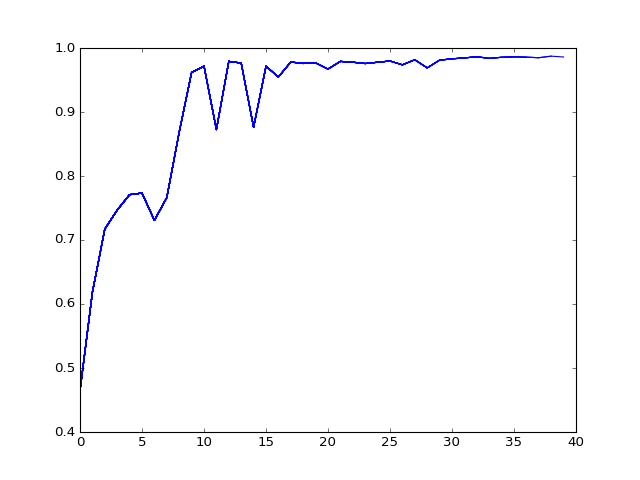

Epoch 0, 0.46448019474013164
Epoch 1, 0.6182397995828635
Epoch 2, 0.7170539984642447
Epoch 3, 0.7467387090011764
Epoch 4, 0.7708566154779449
Epoch 5, 0.7733409578289929
Epoch 6, 0.7306698522297602
Epoch 7, 0.7662656543781001
Epoch 8, 0.8684883382932228
Epoch 9, 0.9617148107289365
Epoch 10, 0.9717119047496808
Epoch 11, 0.8725509249969732
Epoch 12, 0.979111551782913
Epoch 13, 0.9764649622411603
Epoch 14, 0.8761913747171345
Epoch 15, 0.9714684482690372
Epoch 16, 0.9547308473303013
Epoch 17, 0.9781165950658366
Epoch 18, 0.9758245255596565
Epoch 19, 0.9767996406725232
Epoch 20, 0.9670879372580135
Epoch 21, 0.9790707961802123
Epoch 22, 0.977783394171159
Epoch 23, 0.975730169376602
Epoch 24, 0.9777372103805659
Epoch 25, 0.9796843816008333
Epoch 26, 0.9736931674425654
Epoch 27, 0.9816401240705206
Epoch 28, 0.9688998503201162
Epoch 29, 0.981024042014221
Epoch 30, 0.9830859255784601
Epoch 31, 0.9845286213039183
Epoch 32, 0.9862967604852553
Epoch 33, 0.9838418527622588
Epoch 34, 0.985492262917061

In [5]:
# theano.config.optimizer = 'None'
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    interactions=('all', ['xx', 'yy', 'zz']),
    self_interactions=('all', ['x', 'y', 'z']),
    system_qubits=[0, 1, 2]
)
net, funcs = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=40,
    batch_size=2,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


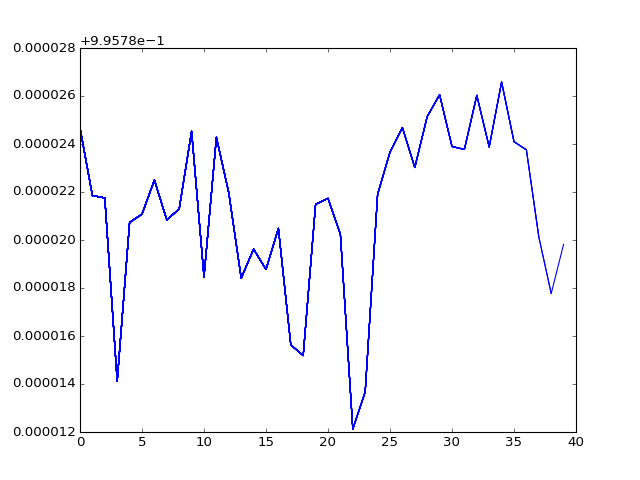

Epoch 0, 0.9958046693013931
Epoch 1, 0.9958018524125385
Epoch 2, 0.9958017526963737
Epoch 3, 0.9957941200324394
Epoch 4, 0.9958007316511601
Epoch 5, 0.9958010772625482
Epoch 6, 0.9958024960151133
Epoch 7, 0.9958008355141758
Epoch 8, 0.9958012965206392
Epoch 9, 0.9958045280888099
Epoch 10, 0.9957984676325506
Epoch 11, 0.9958042791167089
Epoch 12, 0.9958019613344691
Epoch 13, 0.9957984083200434
Epoch 14, 0.9957996204358229
Epoch 15, 0.9957987732145369
Epoch 16, 0.9958004839435628
Epoch 17, 0.9957956308275354
Epoch 18, 0.9957951846176412
Epoch 19, 0.9958014896323625
Epoch 20, 0.9958017340938173
Epoch 21, 0.9958002364660808
Epoch 22, 0.9957921210597034
Epoch 23, 0.9957936707720157
Epoch 24, 0.9958019014387774
Epoch 25, 0.9958036632044964
Epoch 26, 0.9958046854250758
Epoch 27, 0.9958030208927942
Epoch 28, 0.9958051428238106
Epoch 29, 0.9958060517429582
Epoch 30, 0.9958038944060337
Epoch 31, 0.9958037747087339
Epoch 32, 0.9958060258616104
Epoch 33, 0.9958038745815244
Epoch 34, 0.995806582318

In [28]:
net, _ = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=.1,
    n_epochs=40,
    batch_size=5,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.1
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


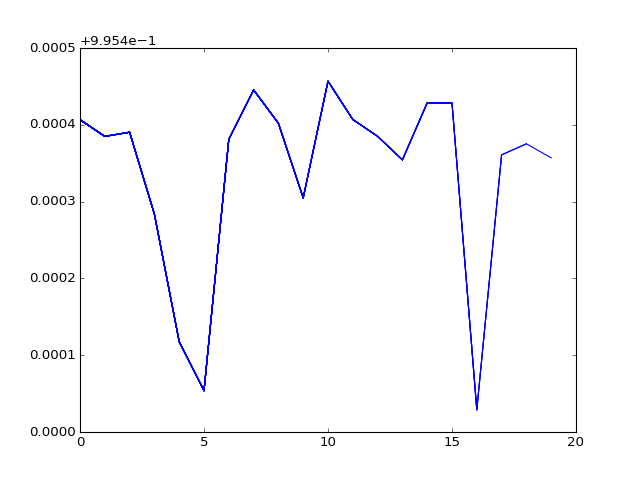

Epoch 0, 0.995806709567658
Epoch 1, 0.9957849373901807
Epoch 2, 0.9957903459300379
Epoch 3, 0.9956836782290429
Epoch 4, 0.995517541478454
Epoch 5, 0.9954537678355057
Epoch 6, 0.9957810918650383
Epoch 7, 0.9958454145837735
Epoch 8, 0.995801969144082
Epoch 9, 0.9957047848006054
Epoch 10, 0.9958567991648106
Epoch 11, 0.9958069010853682
Epoch 12, 0.9957849865387028
Epoch 13, 0.9957543283052068
Epoch 14, 0.9958285952931392
Epoch 15, 0.9958283374809365
Epoch 16, 0.9954289248690545
Epoch 17, 0.9957608905203033
Epoch 18, 0.995775245689815
Epoch 19, 0.9957569744816395
Finished training
Network saved in nets/fredkin_good.pickle


In [65]:
# theano.config.optimizer = 'None'
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    interactions=('all', ['xx', 'yy', 'zz']),
    self_interactions=('all', ['z']),
    system_qubits=[0, 1, 2],
    J=new_Jvalues
)
net, funcs = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=.5,
    n_epochs=20,
    batch_size=2,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01,
    saveafter_file='nets/fredkin_good.pickle'
)

In [11]:
net = QubitNetwork.load_network_from_file('nets/fredkin_best.pickle')
gate = qutip.Qobj(net.get_current_gate(), dims=[[2, 2, 2, 2], [2, 2, 2, 2]])
states, target_states = net.generate_training_data(qutip.fredkin(), 10)

fids = []
for state, target_state in zip(states, target_states):
    ket = qutip.Qobj(utils.bigreal2complex(state), dims=[[2, 2, 2, 2], [1, 1, 1, 1]])
    dm = (gate * ket).ptrace([0, 1, 2])
    target_dm = qutip.ket2dm(qutip.Qobj(utils.bigreal2complex(target_state), dims=[[2, 2, 2], [1, 1, 1]]))
#     display(target_dm)
    fid = np.real((dm * target_dm).tr())
    fids.append(fid)
display(fids)
np.mean(fids)

[array(0.9999930135435516),
 array(0.999992432988932),
 array(0.9999913506274027),
 array(0.9999874878400508),
 array(0.9999899319232368),
 array(0.9999870385640155),
 array(0.9999926557147293),
 array(0.9999886675483851),
 array(0.999989612791072),
 array(0.9999900601338392)]

0.99999022516752145

In [12]:
Jvalues = net.J.get_value()
display(Jvalues)
display([net.J_index_to_interaction(idx) for idx in np.where(np.abs(Jvalues) < 1e-2)[0]])
net.J_index_to_interaction(0)

array([ -3.33662302e-04,   6.29587306e-06,  -1.57899208e-05,
         9.57945427e-05,   3.48637240e-01,   9.58270644e-01,
        -3.31680735e+00,   4.96027968e-02,   2.44559586e-01,
        -6.90826794e-01,   3.23379086e-01,   6.55609475e-01,
        -1.81265239e+00,   3.47624011e-01,   9.56951893e-01,
        -3.31586128e+00,   4.93771621e-02,   2.43686913e-01,
        -6.88574952e-01,  -2.78305496e-02,  -2.43816683e-01,
         1.07247231e+00,  -9.68272064e-01,  -1.22447583e+00,
        -8.84021718e-04,   1.24402550e+00,  -9.69491489e-01,
         1.16198049e-03,   1.27472394e-03,   5.27919157e-03,
         2.35810340e+00,   7.67137183e-01,  -4.07293974e-02,
         1.72312350e-01,  -4.08734884e-02,   6.57406318e-01,
         4.79221787e-01,   1.73037299e-01,   4.79996568e-01,
        -1.03380509e+00,  -9.43497636e-02,  -9.22462741e-02,
         1.55768464e-01,  -1.02434314e-01,  -2.73949437e-01,
         4.65624355e-01,   4.73042385e-01,   9.47372533e-01,
        -1.61224118e+00,

[(0, 'z'),
 (1, 'z'),
 (2, 'z'),
 (3, 'z'),
 ((0, 3), 'xz'),
 ((0, 3), 'yz'),
 ((0, 3), 'zx'),
 ((0, 3), 'zy')]

(0, 'z')

In [205]:
qutip.cnot()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]]

### A Fredkin gate is be obtained with very good fidelity, $\simeq 99.999\%$, starting with all interactions on, and only $\sigma_z$ operators as self-interactions.

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


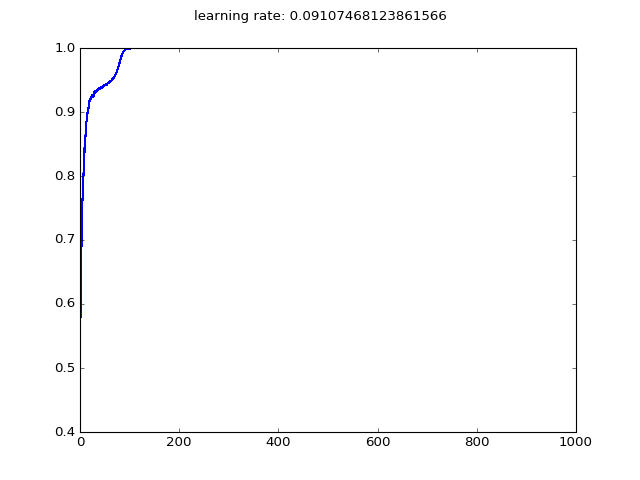

Epoch 0, 0.49349830244497
Epoch 1, 0.5882836291871242
Epoch 2, 0.6581098187119571
Epoch 3, 0.6946326539788646
Epoch 4, 0.7325263214406333
Epoch 5, 0.7638549610402474
Epoch 6, 0.7747101661561526
Epoch 7, 0.8015939031301136
Epoch 8, 0.8205032975822446
Epoch 9, 0.8419416414264436
Epoch 10, 0.8551841037143744
Epoch 11, 0.8630287342967828
Epoch 12, 0.8696771177474922
Epoch 13, 0.8851607333694222
Epoch 14, 0.8863510704498064
Epoch 15, 0.8976485084728124
Epoch 16, 0.9047269079474841
Epoch 17, 0.9059286489449695
Epoch 18, 0.9132610725005091
Epoch 19, 0.9168089671765345
Epoch 20, 0.9204215513138579
Epoch 21, 0.9201361260340822
Epoch 22, 0.9236545288082694
Epoch 23, 0.9233651553551437
Epoch 24, 0.9256042580320742
Epoch 25, 0.9268975016509888
Epoch 26, 0.9257652632050676
Epoch 27, 0.924048463945315
Epoch 28, 0.9299490028235374
Epoch 29, 0.9312504052960259
Epoch 30, 0.93227404277107
Epoch 31, 0.9304854020236912
Epoch 32, 0.9333588168837001
Epoch 33, 0.9332813235245719
Epoch 34, 0.9333800904010154


In [2]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
#     interactions=('all', ['xy', 'xx', 'yy', 'zz']),
    interactions='all',
    self_interactions=('all', ['z']),
    system_qubits=[0, 1, 2]
#     J=new_Jvalues
)
net, funcs = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=10,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01,
    saveafter_file='nets/fredkin_best.pickle'
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


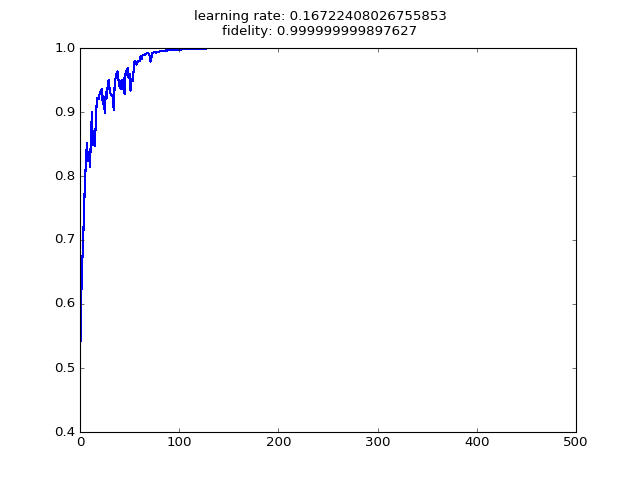

Finished training
Network saved in nets/toffoli.pickle


In [14]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    interactions='all',
    self_interactions=('all', ['z']),
    system_qubits=[0, 1, 2]
#     J=new_Jvalues
)
net, funcs = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=500,
    batch_size=10,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01,
    saveafter_file='nets/toffoli.pickle'
)

In [200]:
net = QubitNetwork.load_network_from_file('nets/fredkin.pickle')
gate = qutip.Qobj(net.get_current_gate(), dims=[[2, 2, 2, 2]] * 2)

ket = qutip.rand_ket(8)
ket.dims = [[2, 2, 2], [1, 1, 1]]
bigket = qutip.tensor(ket, qutip.basis(2, 0))

# display(qutip.ket2dm(ket))
# display(qutip.ket2dm(qutip.toffoli() * ket))

outdm_ = qutip.ket2dm(gate * bigket)
outdm = (gate * bigket).ptrace([0, 1, 2])

gate_anc = np.array([[outdm_[0, 0] / outdm[0, 0], outdm_[0, 1] / outdm[0, 0]],
                     [outdm_[1, 0] / outdm[0, 0], outdm_[1, 1] / outdm[0, 0]]])
gate_anc2 = np.array([[outdm_[0, 2] / outdm[0, 1], outdm_[0, 3] / outdm[0, 1]],
                      [outdm_[1, 2] / outdm[0, 1], outdm_[1, 3] / outdm[0, 1]]])

display(qutip.Qobj(gate_anc))
qutip.Qobj(gate_anc2)

[display(qutip.Qobj(m)) for m in utils.detensorize(outdm_)[:10, :10]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  9.99279771e-01+0.j          -2.40732944e-02-0.01184005j]
 [ -2.40732944e-02+0.01184005j   7.20228997e-04+0.j        ]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  1.00000000e+00+0.j          -2.40906452e-02-0.01184858j]
 [ -2.40906452e-02+0.01184858j   7.20748101e-04+0.j        ]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 1.00000000+0.j          0.02081551+0.08125234j]
 [-0.02409065+0.01184858j -0.00146418-0.00171079j]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[  1.00000000e+00+0.j          -1.80212963e-02+0.06711788j]
 [ -2.40906452e-02+0.01184858j  -3.61107055e-04-0.00183044j]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 1.00000000+0.j         -0.05718125-0.21842448j]
 [-0.02409065+0.01184858j  0.00396555+0.00458447j]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[  1.00000000e+00+0.j          -1.03722877e-02+0.00448853j]
 [ -2.40906452e-02+0.01184858j   1.96692335e-04-0.00023103j]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[  1.00000000e+00+0.j           4.16859600e-02-0.04450399j]
 [ -2.40906452e-02+0.01184858j  -4.76932404e-04+0.00156605j]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 1.00000000+0.j         -0.14948373-0.04685318j]
 [-0.02409065+0.01184858j  0.00415630-0.00064245j]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 1.00000000+0.j         -0.10149584-0.20109804j]
 [-0.02409065+0.01184858j  0.00482783+0.003642j  ]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 1.00000000+0.j         -0.02409065-0.01184858j]
 [ 0.02081551-0.08125234j -0.00146418+0.00171079j]]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.00000000+0.j          0.02081551+0.08125234j]
 [ 0.02081551-0.08125234j  0.00703523+0.j        ]]

[None, None, None, None, None, None, None, None, None, None]

In [34]:
rand_U = qutip.rand_unitary(8, dims=[[2, 2, 2]] * 2)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


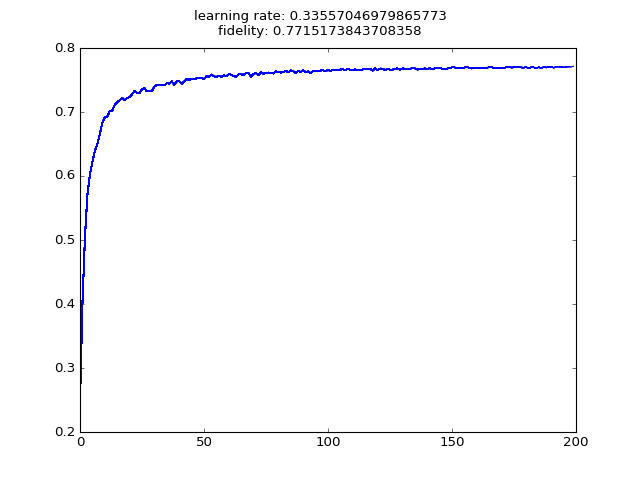

Finished training
Network saved in nets/random.pickle


In [33]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    interactions='all',
    self_interactions=('all', ['z']),
    system_qubits=[0, 1, 2]
)
net, funcs = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=200,
    batch_size=10,
    target_gate=rand_U,
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01,
    saveafter_file='nets/random.pickle'
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


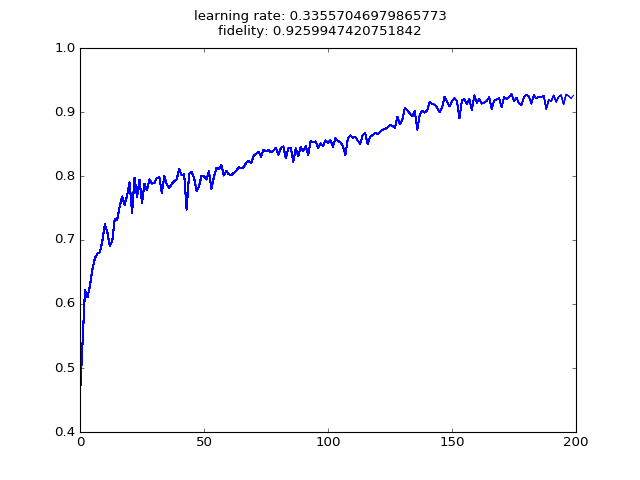

Finished training
Network saved in nets/random2.pickle


In [36]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    interactions='all',
    self_interactions='all',
    system_qubits=[0, 1, 2]
)
net, funcs = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=200,
    batch_size=2,
    target_gate=rand_U,
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01,
    saveafter_file='nets/random2.pickle'
)

In [39]:
qutip.hadamard_transform(3)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.35355339  0.35355339  0.35355339  0.35355339  0.35355339  0.35355339
   0.35355339  0.35355339]
 [ 0.35355339 -0.35355339  0.35355339 -0.35355339  0.35355339 -0.35355339
   0.35355339 -0.35355339]
 [ 0.35355339  0.35355339 -0.35355339 -0.35355339  0.35355339  0.35355339
  -0.35355339 -0.35355339]
 [ 0.35355339 -0.35355339 -0.35355339  0.35355339  0.35355339 -0.35355339
  -0.35355339  0.35355339]
 [ 0.35355339  0.35355339  0.35355339  0.35355339 -0.35355339 -0.35355339
  -0.35355339 -0.35355339]
 [ 0.35355339 -0.35355339  0.35355339 -0.35355339 -0.35355339  0.35355339
  -0.35355339  0.35355339]
 [ 0.35355339  0.35355339 -0.35355339 -0.35355339 -0.35355339 -0.35355339
   0.35355339  0.35355339]
 [ 0.35355339 -0.35355339 -0.35355339  0.35355339 -0.35355339  0.35355339
   0.35355339 -0.35355339]]

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


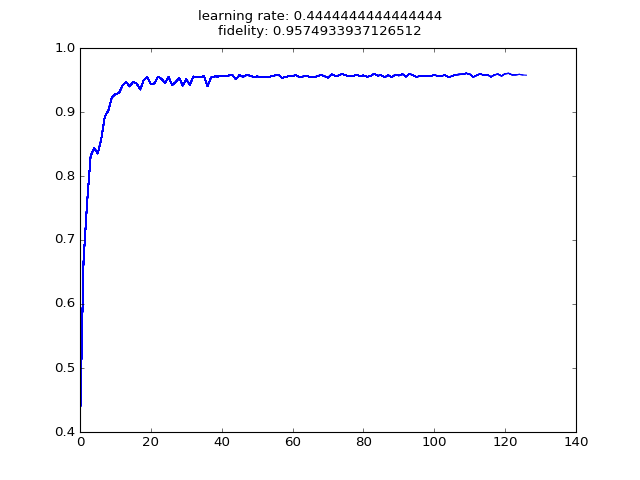

KeyboardInterrupt: 

In [41]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    interactions='all',
    self_interactions='all',
    system_qubits=3
)
net, funcs = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=200,
    batch_size=2,
    target_gate=qutip.hadamard_transform(3),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01,
    saveafter_file='nets/hadamard.pickle'
)